# Feature engineering

### Libraries and loads data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import category_encoders as ce
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
# Load the cleaned dataset
filepath = "/Users/ziqismac/Desktop/SML/Project/data/US_Accidents_Cleaned.csv"
df_cleaned = pd.read_csv(filepath)
df_featured = df_cleaned.copy()

print("Data size after cleaning:", df_cleaned.shape)

numerical = df_cleaned.select_dtypes(include=['int64', 'float64'])
categorical = df_cleaned.select_dtypes(include=['object', 'category'])
boolean = df_cleaned.select_dtypes(include=['bool'])

# Print the number of features in each type
print(f"Numerical features: {numerical.shape[1]}")
print(f"Categorical features: {categorical.shape[1]}")
print(f"Boolean features: {boolean.shape[1]}")


Data size after cleaning: (100000, 46)
Numerical features: 13
Categorical features: 20
Boolean features: 13


## Categorical features preprocessing

In [3]:
# Display unique values in each categorical column
for col in categorical.columns:
    print(f"{col}: {categorical[col].nunique()} unique values")

ID: 100000 unique values
Source: 1 unique values
Start_Time: 92428 unique values
End_Time: 94182 unique values
Description: 71543 unique values
Street: 27197 unique values
City: 6941 unique values
County: 1406 unique values
State: 49 unique values
Zipcode: 32690 unique values
Country: 1 unique values
Timezone: 4 unique values
Airport_Code: 1641 unique values
Weather_Timestamp: 60510 unique values
Wind_Direction: 23 unique values
Weather_Condition: 83 unique values
Sunrise_Sunset: 3 unique values
Civil_Twilight: 3 unique values
Nautical_Twilight: 3 unique values
Astronomical_Twilight: 3 unique values


In [4]:
# Drop irrelevant categorical columns
Irrelevant_columns = ['ID', 'Source', 'Country']  # Replace with actual column names
df_featured = df_featured.drop(columns=Irrelevant_columns)

### Time related feature

In [5]:
# Convert format of time related features
df_featured['Start_Time'] = pd.to_datetime(df_featured['Start_Time'], errors='coerce')
df_featured['End_Time'] = pd.to_datetime(df_featured['End_Time'], errors='coerce')

# Extract time-based features
df_featured['Start_Hour'] = df_featured['Start_Time'].dt.hour
df_featured['Start_Day'] = df_featured['Start_Time'].dt.day
df_featured['Start_Month'] = df_featured['Start_Time'].dt.month
df_featured['Start_Year'] = df_featured['Start_Time'].dt.year
df_featured['Start_DayOfWeek'] = df_featured['Start_Time'].dt.dayofweek
df_featured['is_Weekend'] = df_featured['Start_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_featured['duration_minutes'] = (df_featured['End_Time'] - df_featured['Start_Time']).dt.total_seconds() / 60

# Preserve closeness of hours, day of weeks, and months
df_featured['Start_Hour_sin'] = np.sin(2 * np.pi * df_featured['Start_Hour'] / 24)
df_featured['Start_Hour_cos'] = np.cos(2 * np.pi * df_featured['Start_Hour'] / 24)
df_featured['Start_DayOfWeek_sin'] = np.sin(2 * np.pi * df_featured['Start_DayOfWeek'] / 7)
df_featured['Start_DayOfWeek_cos'] = np.cos(2 * np.pi * df_featured['Start_DayOfWeek'] / 7)
df_featured['Start_Month_sin'] = np.sin(2 * np.pi * df_featured['Start_Month'] / 12)
df_featured['Start_Month_cos'] = np.cos(2 * np.pi * df_featured['Start_Month'] / 12)

# Construct features for rush hours
df_featured['is_RushHour_Morning'] = df_featured['Start_Hour'].apply(lambda x: 1 if 7 <= x <= 9 else 0)
df_featured['is_RushHour_Evening'] = df_featured['Start_Hour'].apply(lambda x: 1 if 16 <= x <= 18 else 0)

# Construct Seasonal features
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
df_featured['Season'] = df_featured['Start_Month'].apply(get_season)
df_featured = pd.get_dummies(df_featured, columns=['Season'], prefix='is', drop_first=True, dtype=int)


### Location related feature

/var/folders/t9/qfn6nmkj7qn5hz4ksvt8v0bc0000gn/T/ipykernel_41353/1352639575.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_100_cities.index, x=top_100_cities.values, palette="viridis")


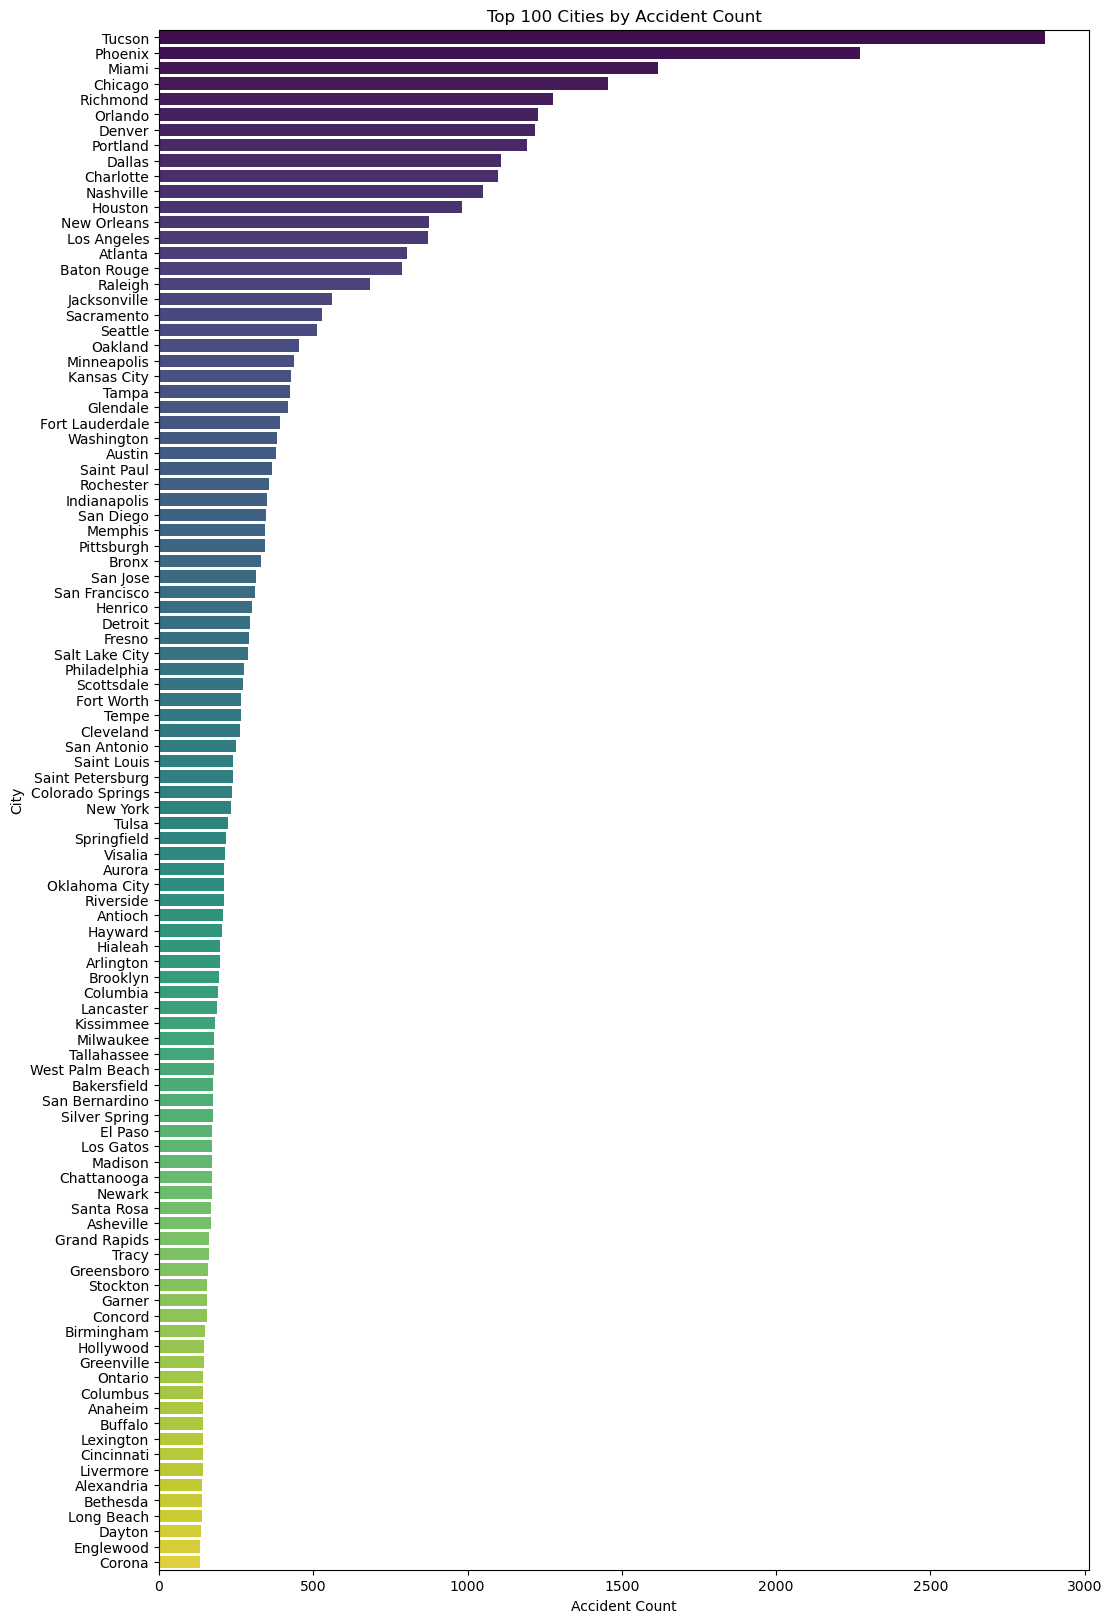

/var/folders/t9/qfn6nmkj7qn5hz4ksvt8v0bc0000gn/T/ipykernel_41353/1352639575.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_100_counties.index, x=top_100_counties.values, palette="magma")


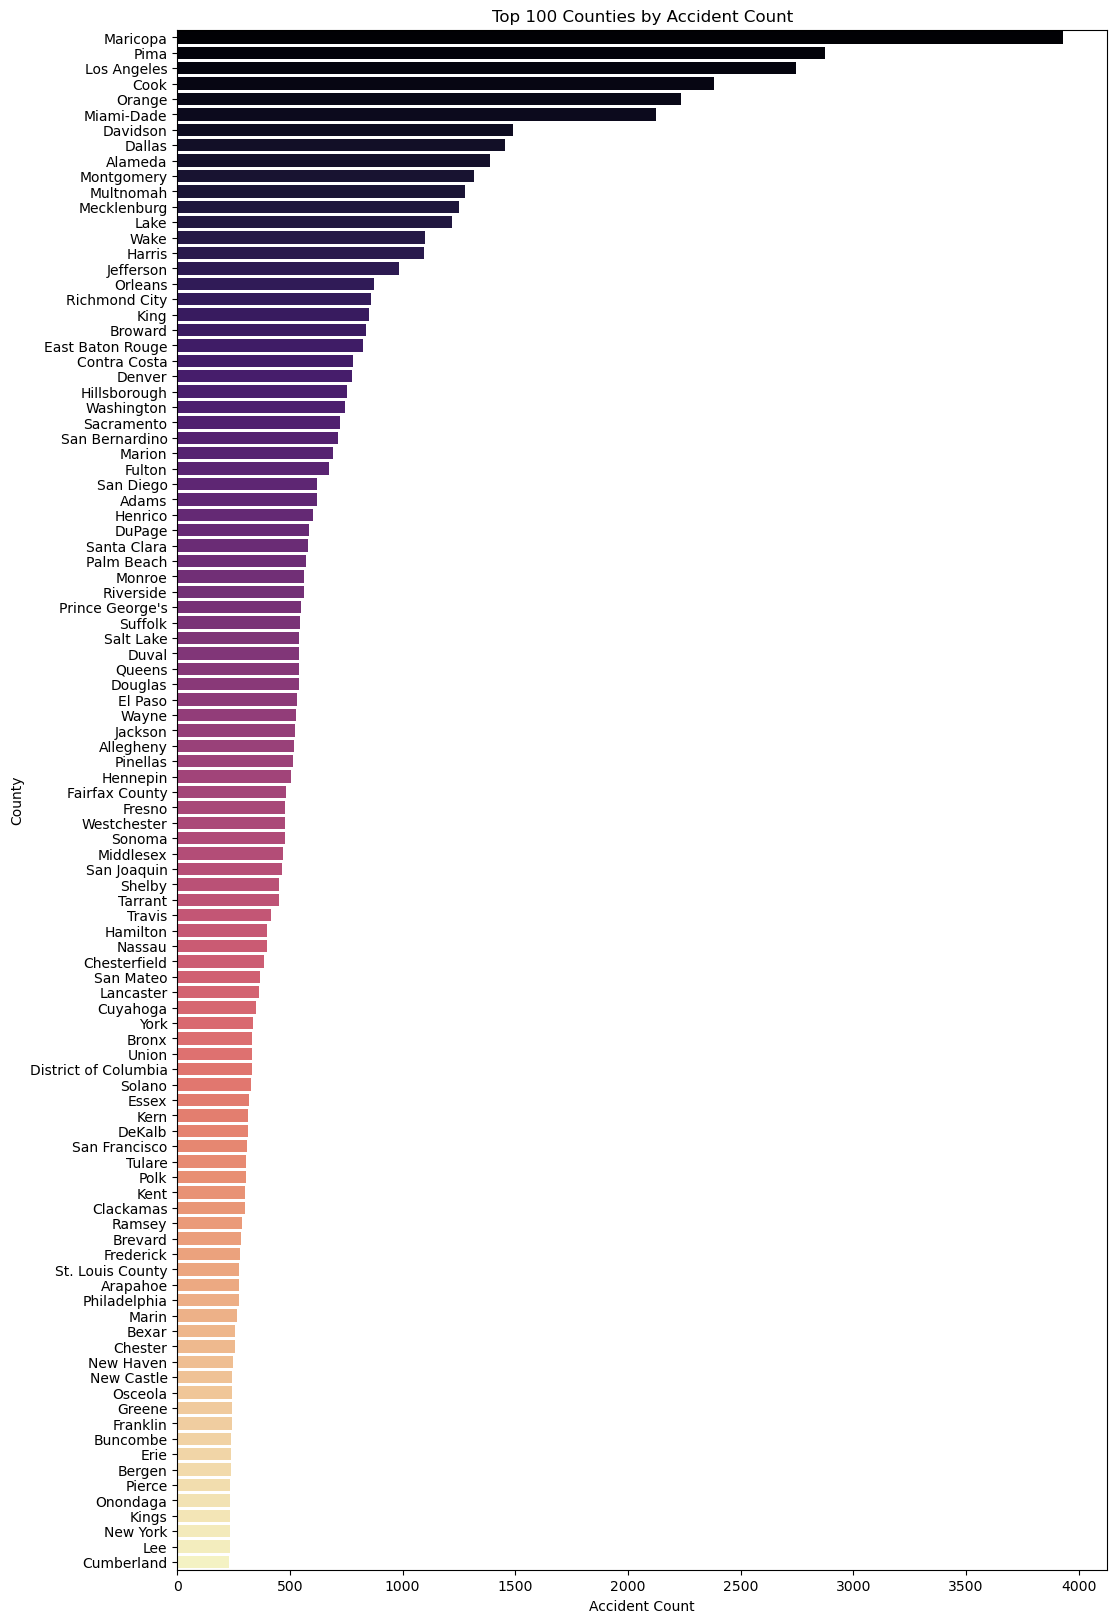

In [6]:
city_counts = df_featured['City'].value_counts().sort_values(ascending=False)
top_100_cities = city_counts.head(100)
county_counts = df_featured['County'].value_counts().sort_values(ascending=False)
top_100_counties = county_counts.head(100)

# Visualize top 100 cities and counties by accident counts
plt.figure(figsize=(12,20))
sns.barplot(y=top_100_cities.index, x=top_100_cities.values, palette="viridis")
plt.title(f"Top 100 Cities by Accident Count")
plt.xlabel("Accident Count")
plt.ylabel("City")
plt.show()

plt.figure(figsize=(12,20))
sns.barplot(y=top_100_counties.index, x=top_100_counties.values, palette="magma")
plt.title(f"Top 100 Counties by Accident Count")
plt.xlabel("Accident Count")
plt.ylabel("County")
plt.show()


Since the distribution of 'cities' and 'counties' are concentrated and skewed, we are safe to perform top 30 one-hot encoding for them

In [7]:
# binary encoding for 'Street' and 'zipcode'
encoder = ce.BinaryEncoder(cols=['Street', 'Zipcode'])
df_encoded = encoder.fit_transform(df_featured)

# One-hot encoding for top 30 cities and counties
top_50_cities = city_counts.head(30)
top_50_counties = county_counts.head(30)
for city in top_50_cities.index:
    df_featured[f'City_{city}'] = (df_featured['City'] == city).astype(int)
for county in top_50_counties.index:
    df_featured[f'County_{county}'] = (df_featured['County'] == county).astype(int)

# One-hot encoding for 'State'
state_dummies = pd.get_dummies(df_featured, columns=['State'], prefix='State', drop_first=True)

# One-hot encoding for 'Timezone'
timezone_dummies = pd.get_dummies(df_featured, columns=['Timezone'], prefix='Timezone', drop_first=True)

# Drop original 'City', 'County', 'Street', and 'Zipcode' columns
df_featured = df_featured.drop(columns=['City', 'County', 'Street', 'Zipcode', 'State', 'Timezone'])


### Weather related features

In [8]:
# Drop the 'airport_code' column due to high cardinality and low relevance
df_featured = df_featured.drop(columns=['Airport_Code'])

# Compute the lag between weather timestamp and accident start time
df_featured['Weather_Timestamp'] = pd.to_datetime(df_featured['Weather_Timestamp'], errors='coerce')
df_featured['Weather_Lag_Mins'] = (df_featured['Start_Time'] - df_featured['Weather_Timestamp']).dt.total_seconds() / 60

# Drop original time columns
df_featured = df_featured.drop(columns=['Start_Time', 'End_Time', 'Weather_Timestamp'])


In [9]:
# Process Wind Direction
print(df_featured["Wind_Direction"].unique())

# Mapping wind direction to numerical values
wind_dir_map = {
    'N': 0, 'North': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90, 'East': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180, 'South': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270, 'West': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5,
    'CALM': np.nan, 'VAR': np.nan, 'Variable': np.nan,
}

# Apply mapping
df_featured['Wind_Direction_Degrees'] = df_featured['Wind_Direction'].map(wind_dir_map)

# Use cyclic encoding for wind direction
df_featured['Wind_Direction_sin'] = np.sin(2 * np.pi * df_featured['Wind_Direction_Degrees'] / 360)
df_featured['Wind_Direction_cos'] = np.cos(2 * np.pi * df_featured['Wind_Direction_Degrees'] / 360)

# Drop original 'Wind_Direction' and intermediate 'Wind_Direction_Degrees' columns
df_featured = df_featured.drop(columns=['Wind_Direction', 'Wind_Direction_Degrees'])

['NW' 'CALM' 'NNE' 'SSE' 'W' 'WNW' 'E' 'N' 'S' 'NE' 'North' 'ESE' 'SSW'
 'SW' 'SE' 'VAR' 'WSW' 'ENE' 'NNW' 'East' 'South' 'West' 'Variable']


In [10]:
# Process Weather_Condition
print(df_featured["Weather_Condition"].unique())

# Construct a weather map
weather_map = {
    # Clear
    'Clear': 'Clear', 'Fair': 'Clear', 'Fair / Windy': 'Clear',
    
    # Cloudy
    'Cloudy': 'Cloudy', 'Mostly Cloudy': 'Cloudy', 'Partly Cloudy': 'Cloudy',
    'Overcast': 'Cloudy', 'Scattered Clouds': 'Cloudy',
    'Cloudy / Windy': 'Cloudy', 'Mostly Cloudy / Windy': 'Cloudy',
    'Partly Cloudy / Windy': 'Cloudy',
    
    # Rain / Drizzle
    'Rain': 'Rain', 'Light Rain': 'Rain', 'Heavy Rain': 'Rain',
    'Light Drizzle': 'Rain', 'Drizzle': 'Rain', 'Heavy Drizzle': 'Rain',
    'Showers in the Vicinity': 'Rain', 'Light Rain Showers': 'Rain',
    'Light Rain Shower': 'Rain', 'Light Rain / Windy': 'Rain',
    'Rain / Windy': 'Rain', 'Drizzle / Windy': 'Rain',
    'Light Drizzle / Windy': 'Rain',
    
    # Thunderstorms
    'T-Storm': 'Storm', 'Heavy T-Storm': 'Storm',
    'Heavy T-Storm / Windy': 'Storm', 'Thunder': 'Storm',
    'Thunder / Windy': 'Storm', 'Thunder in the Vicinity': 'Storm',
    'Thunderstorms and Rain': 'Storm', 'Heavy Thunderstorms and Rain': 'Storm',
    'Light Thunderstorms and Rain': 'Storm',
    'Thunder and Hail': 'Storm', 'T-Storm / Windy': 'Storm',
    'Thunder / Wintry Mix': 'Storm', 'Thunder / Wintry Mix / Windy': 'Storm',
    'Light Thunderstorms and Snow': 'Storm',
    
    # Snow
    'Snow': 'Snow', 'Light Snow': 'Snow', 'Heavy Snow': 'Snow',
    'Blowing Snow': 'Snow', 'Drifting Snow': 'Snow',
    'Light Snow / Windy': 'Snow', 'Snow / Windy': 'Snow',
    'Heavy Snow / Windy': 'Snow', 'Blowing Snow / Windy': 'Snow',
    'Drifting Snow / Windy': 'Snow',
    
    # Wintry Mix / Ice
    'Wintry Mix': 'Ice', 'Wintry Mix / Windy': 'Ice',
    'Sleet': 'Ice', 'Light Sleet': 'Ice',
    'Snow and Sleet': 'Ice', 'Snow and Sleet / Windy': 'Ice',
    'Light Snow and Sleet': 'Ice', 'Light Snow and Sleet / Windy': 'Ice',
    'Ice Pellets': 'Ice', 'Light Ice Pellets': 'Ice',
    'Freezing Rain': 'Ice', 'Light Freezing Rain': 'Ice',
    'Light Freezing Rain / Windy': 'Ice',
    'Light Freezing Drizzle': 'Ice', 'Light Freezing Fog': 'Ice',
    
    # Fog / Mist / Haze
    'Fog': 'Fog', 'Fog / Windy': 'Fog',
    'Shallow Fog': 'Fog', 'Patches of Fog': 'Fog',
    'Patches of Fog / Windy': 'Fog', 'Mist': 'Fog',
    'Drizzle and Fog': 'Fog', 'Haze': 'Fog', 'Haze / Windy': 'Fog',
    
    # Smoke / Dust
    'Smoke': 'Dust/Smoke', 'Smoke / Windy': 'Dust/Smoke',
    'Widespread Dust': 'Dust/Smoke', 'Blowing Dust': 'Dust/Smoke',
    'Blowing Dust / Windy': 'Dust/Smoke', 'Sand / Dust Whirlwinds': 'Dust/Smoke',
    'Squalls / Windy': 'Dust/Smoke',
    
    # Severe
    'Tornado': 'Severe',
    
    # Unknown
    'Unknown': 'Unknown', 'N/A Precipitation': 'Unknown'
}

# Apply the mapping
df_featured['Weather_Condition_Cat'] = df_featured['Weather_Condition'].map(weather_map)

# One-hot encode the new weather condition categories
df_featured = pd.get_dummies(df_featured, columns=['Weather_Condition_Cat'], prefix='Weather', drop_first=True, dtype=int)

# Drop original 'Weather_Condition'
df_featured = df_featured.drop(columns=['Weather_Condition'])


['Cloudy' 'Fair' 'Mostly Cloudy' 'Partly Cloudy' 'T-Storm'
 'Heavy Rain / Windy' 'Light Snow' 'Fog' 'Light Rain' 'Light Drizzle'
 'Heavy T-Storm' 'Heavy Rain' 'Rain' 'Light Rain / Windy'
 'Mostly Cloudy / Windy' 'Haze' 'Thunder in the Vicinity' 'Thunder'
 'Fair / Windy' 'Overcast' 'Snow' 'Drizzle' 'Light Rain with Thunder'
 'Heavy T-Storm / Windy' 'Showers in the Vicinity' 'Wintry Mix'
 'Cloudy / Windy' 'Unknown' 'Light Snow / Windy' 'Clear' 'Smoke'
 'Light Freezing Drizzle' 'Partly Cloudy / Windy' 'Scattered Clouds'
 'Fog / Windy' 'Heavy Snow' 'Rain / Windy' 'Snow / Windy'
 'Sand / Dust Whirlwinds' 'Smoke / Windy' 'Light Sleet'
 'Light Freezing Rain' 'Shallow Fog' 'Heavy Snow / Windy'
 'Light Ice Pellets' 'Snow and Sleet / Windy' 'N/A Precipitation'
 'Patches of Fog' 'Blowing Snow / Windy' 'Widespread Dust' 'Blowing Snow'
 'T-Storm / Windy' 'Drizzle and Fog' 'Mist' 'Freezing Rain' 'Haze / Windy'
 'Drizzle / Windy' 'Light Rain Shower' 'Thunder / Wintry Mix / Windy'
 'Light Drizzle / Wi

In [11]:
# Print unique values for Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight:
print(df_featured['Sunrise_Sunset'].unique())
print(df_featured['Civil_Twilight'].unique())
print(df_featured['Nautical_Twilight'].unique())
print(df_featured['Astronomical_Twilight'].unique())

# Construct a binary mapping
twilight_map = {
    'Day': 1,
    'Night': 0,
    'Unknown': -1,
}

binary_cols_to_map = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
for col in binary_cols_to_map:
    df_featured[col + '_binary'] = df_featured[col].map(twilight_map)
    df_featured = df_featured.drop(columns=[col])

['Day' 'Night' 'Unknown']
['Day' 'Night' 'Unknown']
['Day' 'Night' 'Unknown']
['Day' 'Night' 'Unknown']


### Description Feature (Pretrained Sentence Embedding)

In [12]:
# Load pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the 'Description' column
descriptions = df_featured['Description'].fillna("").tolist()
embeddings = model.encode(descriptions, show_progress_bar=True, batch_size=64)
print(f"Generated embeddings shape: {embeddings[:3]}")

# Convert embeddings to DataFrame
embeddings_df = pd.DataFrame(embeddings, columns=[f'Desc_Emb_{i}' for i in range(embeddings.shape[1])])
df_featured = pd.concat([df_featured.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)

# Drop original 'Description' column
df_featured = df_featured.drop(columns=['Description'])

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Generated embeddings shape: [[-0.05856315  0.03276988  0.01098151 ... -0.09794001 -0.10846034
  -0.05505113]
 [ 0.00468834  0.03403154 -0.05535972 ... -0.0220419  -0.03482661
   0.06545306]
 [-0.00481817 -0.01048493 -0.0068672  ...  0.13006358 -0.06317224
  -0.0495757 ]]


## Boolean Features Processing

In [13]:
# Display unique values in each Boolean column
for col in boolean.columns:
    print(f"{col}: {boolean[col].nunique()} unique values")
    #Print unique values in each Boolean column
    print(boolean[col].unique())

Amenity: 2 unique values
[False  True]
Bump: 2 unique values
[False  True]
Crossing: 2 unique values
[False  True]
Give_Way: 2 unique values
[False  True]
Junction: 2 unique values
[False  True]
No_Exit: 2 unique values
[False  True]
Railway: 2 unique values
[False  True]
Roundabout: 1 unique values
[False]
Station: 2 unique values
[False  True]
Stop: 2 unique values
[False  True]
Traffic_Calming: 2 unique values
[False  True]
Traffic_Signal: 2 unique values
[False  True]
Turning_Loop: 1 unique values
[False]


In [14]:
# Drop irrelevant boolean columns
Irrelevant_boolean_columns = ['Roundabout', 'Turning_Loop']
df_featured = df_featured.drop(columns=Irrelevant_boolean_columns)

# Binarize remaining boolean columns
for col in boolean.columns:
    if col not in Irrelevant_boolean_columns:
        df_featured[col] = df_featured[col].astype(int)



### 

## Numerical features Processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           100000 non-null  int64  
 1   Start_Lat          100000 non-null  float64
 2   Start_Lng          100000 non-null  float64
 3   End_Lat            100000 non-null  float64
 4   End_Lng            100000 non-null  float64
 5   Distance(mi)       100000 non-null  float64
 6   Temperature(F)     100000 non-null  float64
 7   Wind_Chill(F)      100000 non-null  float64
 8   Humidity(%)        100000 non-null  float64
 9   Pressure(in)       100000 non-null  float64
 10  Visibility(mi)     100000 non-null  float64
 11  Wind_Speed(mph)    100000 non-null  float64
 12  Precipitation(in)  100000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 9.9 MB
None


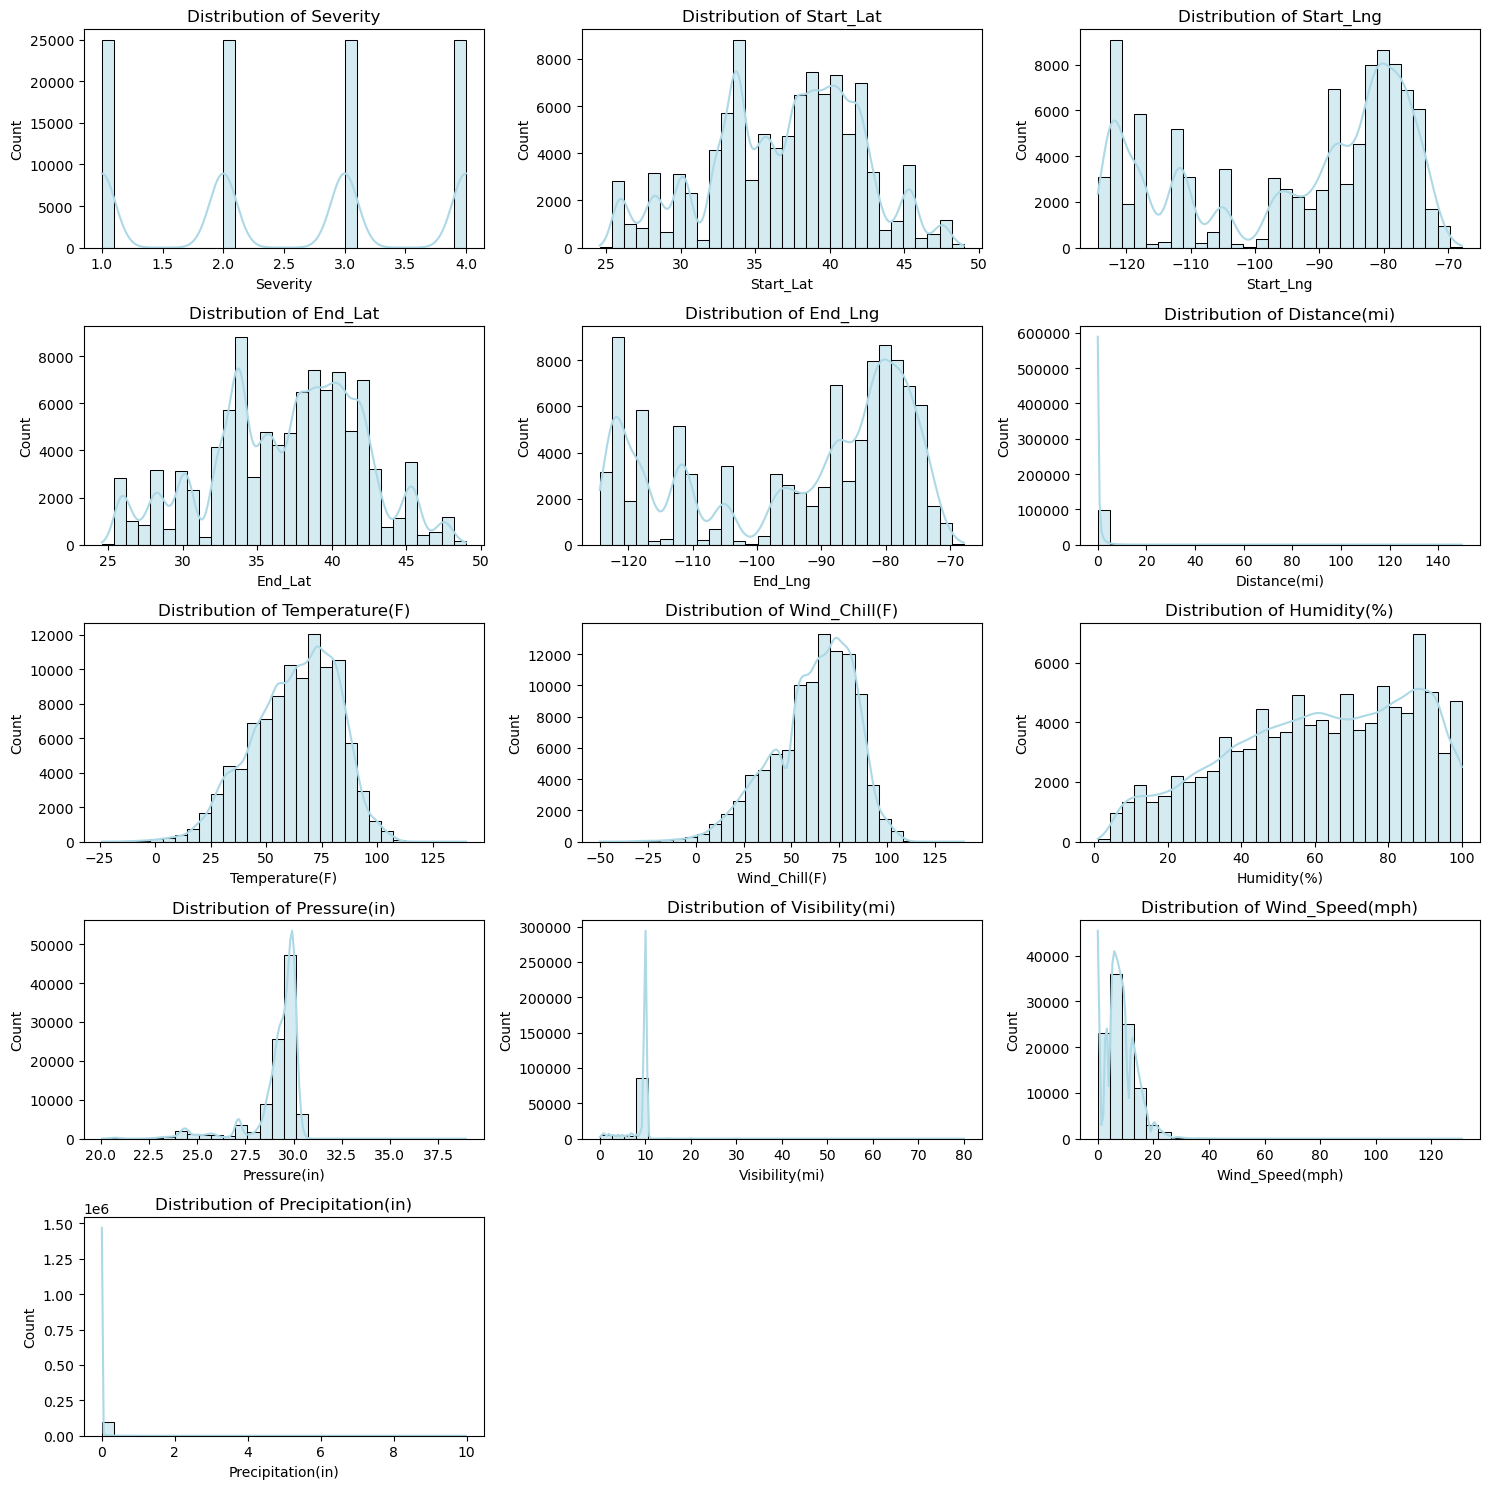

In [15]:
# Display numerical feature
print(numerical.info())

# Plot the distribution of each numerical features
numerical.drop(columns=['Severity'])
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical.columns):
    plt.subplot(len(numerical.columns)//3 + 1, 3, i + 1)
    sns.histplot(df_featured[col], kde=True, bins=30, color='lightblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Process geocoordinate features

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


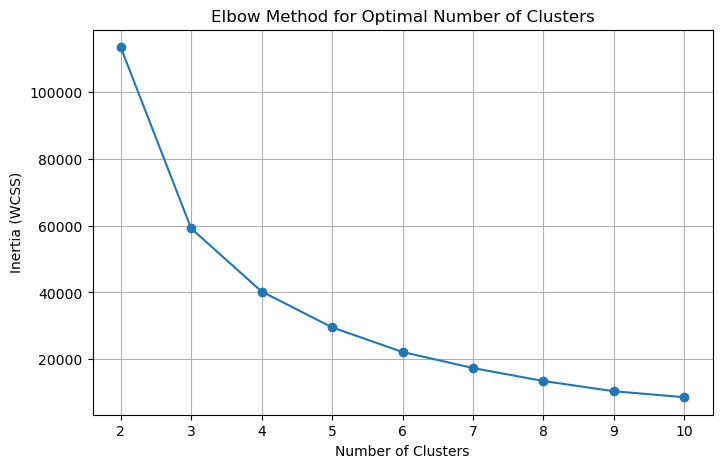

For n_clusters = 4, the average silhouette_score is : 0.5423612290875907
For n_clusters = 5, the average silhouette_score is : 0.5004175961252736
For n_clusters = 6, the average silhouette_score is : 0.5276485264260956


In [16]:
TOKENIZERS_PARALLELISM = "false"

# Process geocoordinate features using KMeans clustering
geo_features = df_featured[['Start_Lat', 'Start_Lng']]

# Standardize the geocoordinate features
scaler = StandardScaler()
geo_features_scaled = scaler.fit_transform(geo_features)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(geo_features_scaled)
    inertia.append(kmeans.inertia_) #WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Examine the silhouette scores for different cluster counts
silhouette_scores = []
for n_clusters in range(4, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(geo_features_scaled)
    silhouette_avg = silhouette_score(geo_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

In [17]:
# Choose 4 clusters based on the Elbow Method and silhouette scores
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_featured['Geo_Cluster'] = kmeans.fit_predict(geo_features_scaled)
print(df_featured['Geo_Cluster'].value_counts())

# Drop original 'Start_Lat' and 'Start_Lng' columns
df_featured = df_featured.drop(columns=['Start_Lat', 'Start_Lng'])
# Drop 'End_Lat' and 'End_Lng' columns
df_featured = df_featured.drop(columns=['End_Lat', 'End_Lng'])



Geo_Cluster
1    43975
2    27356
0    22456
3     6213
Name: count, dtype: int64


### Process weather related numerical feature

In [18]:
# Print statistics of Weather related numerical features
weather_numerical_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Chill(F)',
                           'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
print(df_featured[weather_numerical_cols].describe())

       Temperature(F)    Humidity(%)   Pressure(in)  Wind_Chill(F)  \
count   100000.000000  100000.000000  100000.000000  100000.000000   
mean        62.988663      61.464672      29.131678      61.746069   
std         19.112001      24.854572       1.397354      21.236662   
min        -24.000000       1.000000      20.060000     -50.100000   
25%         50.000000      43.000000      29.020000      50.000000   
50%         65.000000      64.000000      29.570000      65.000000   
75%         78.000000      83.000000      29.920000      78.000000   
max        140.000000     100.000000      38.940000     140.000000   

       Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  
count   100000.000000    100000.000000      100000.000000  
mean         9.147323         7.975792           0.007082  
std          2.897423         5.536959           0.083788  
min          0.000000         0.000000           0.000000  
25%         10.000000         5.000000           0.000000  
50%      

In [19]:
# log-transform skewed features
skewed_features = ['Wind_Speed(mph)', 'Visibility(mi)']
for feature in skewed_features:
    df_featured[feature] = np.log1p(df_featured[feature])

# Construct binary features for precipitation
df_featured['Has_Precipitation'] = (df_featured['Precipitation(in)'] > 0).astype(int)

# Normalize rest of numerical features
for feature in weather_numerical_cols:
    if feature not in skewed_features and feature != 'Precipitation(in)':
        df_featured[feature] = scaler.fit_transform(df_featured[[feature]])
        

## Examine the final constructed dataset and save

In [20]:
# Examine the final constructed dataset and save
print("Final dataset shape:", df_featured.shape)
for col in df_featured.columns:
    print(f"{col}: {df_featured[col].nunique()} unique values with type {df_featured[col].dtype}")

Final dataset shape: (100000, 500)
Severity: 4 unique values with type int64
Distance(mi): 5968 unique values with type float64
Temperature(F): 218 unique values with type float64
Wind_Chill(F): 545 unique values with type float64
Humidity(%): 101 unique values with type float64
Pressure(in): 930 unique values with type float64
Visibility(mi): 46 unique values with type float64
Wind_Speed(mph): 73 unique values with type float64
Precipitation(in): 120 unique values with type float64
Amenity: 2 unique values with type int64
Bump: 2 unique values with type int64
Crossing: 2 unique values with type int64
Give_Way: 2 unique values with type int64
Junction: 2 unique values with type int64
No_Exit: 2 unique values with type int64
Railway: 2 unique values with type int64
Station: 2 unique values with type int64
Stop: 2 unique values with type int64
Traffic_Calming: 2 unique values with type int64
Traffic_Signal: 2 unique values with type int64
Start_Hour: 24 unique values with type float64
St

In [21]:
# Double check for any non-numerical columns
for col in df_featured.columns:
    if df_featured[col].dtype != 'int64' and df_featured[col].dtype != 'int32' and df_featured[col].dtype != 'float64' and df_featured[col].dtype != 'float32':
        print(f"Column {col} has dtype {df_featured[col].dtype}")

In [ ]:
df_featured.to_csv("/Users/ziqismac/Desktop/SML/Project/data/US_Accidents_Featured.csv", index=False)